In [20]:
from robust_motifs.data import save_er_graph
from robust_motifs.custom_mp import prepare_shared_memory
from robust_motifs.counting import get_dag2_signature
from pathlib import Path
from robust_motifs.data import load_sparse_matrix
import h5py
from time import time
import multiprocessing as mp
from itertools import product
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Creating ER graphs for timing

In [21]:
for n_nodes in [5000,7500,10000,12500,15000,17500,20000]:
    path = Path("data/timing/n_nodes/ER_" + str(n_nodes) + ".flag")
    path.parent.mkdir(parents=True, exist_ok = True)
    save_er_graph(path, n_nodes, 0.01)

100%|██████████| 5000/5000 [00:00<00:00, 3158361.45it/s]
249833it [00:00, 665231.22it/s]
100%|██████████| 7500/7500 [00:00<00:00, 3312338.63it/s]
562722it [00:00, 664044.64it/s]
100%|██████████| 10000/10000 [00:00<00:00, 3337819.51it/s]
1000025it [00:01, 676702.56it/s]
100%|██████████| 12500/12500 [00:00<00:00, 3381848.67it/s]
1561134it [00:02, 691222.72it/s]
100%|██████████| 15000/15000 [00:00<00:00, 3374882.52it/s]
2248486it [00:03, 687528.04it/s]
100%|██████████| 17500/17500 [00:00<00:00, 3206514.35it/s]
3060971it [00:04, 681181.34it/s]
100%|██████████| 20000/20000 [00:00<00:00, 3291973.94it/s]
4001618it [00:05, 668019.73it/s]


In [28]:
!flagser-count data/timing/n_nodes/ER_20000.flag --out data/timing/n_nodes/ER_20000-count.h5

# [euler_characteristic cell_count_dim_0 cell_count_dim_1 ...]
3866865 20000 4001618 8008641 160188 30


In [29]:
for density in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]:
    path = Path("data/timing/density/ER_" + str(density) + ".flag")
    path.parent.mkdir(parents=True, exist_ok = True)
    save_er_graph(path, 10000, density)

100%|██████████| 10000/10000 [00:00<00:00, 3212549.02it/s]
999366it [00:01, 674154.75it/s]
100%|██████████| 10000/10000 [00:00<00:00, 3362706.65it/s]
2000099it [00:02, 668565.96it/s]
100%|██████████| 10000/10000 [00:00<00:00, 3142977.89it/s]
3000762it [00:04, 670029.89it/s]
100%|██████████| 10000/10000 [00:00<00:00, 3373253.98it/s]
3999494it [00:05, 679112.46it/s]
100%|██████████| 10000/10000 [00:00<00:00, 3316704.10it/s]
4997362it [00:07, 690459.28it/s]
100%|██████████| 10000/10000 [00:00<00:00, 3279105.62it/s]
5996957it [00:08, 687373.11it/s]
100%|██████████| 10000/10000 [00:00<00:00, 3202736.71it/s]
7000417it [00:10, 690021.37it/s]


In [47]:
!flagser-count data/timing/density/ER_0.06.flag --out data/timing/density/ER_0.06-count.h5

# [euler_characteristic cell_count_dim_0 cell_count_dim_1 ...]
-195611523 10000 5996957 215640433 464868050 60067950 465124 225


# Counting simplex-containing DAG2

### On number of nodes.

In [37]:
def get_combinations(boolean_array):
    elems = [[False,True] if elem else [False] for elem in boolean_array]
    return product(*elems)

In [40]:
times_1 = []
times_2 = []

for n_nodes in tqdm([5000,7500,10000,12500,15000,17500,20000]):
    er_flag_path = Path("data/timing/n_nodes/ER_" + str(n_nodes) + ".flag")
    er_matrix_path = er_flag_path.with_suffix('.pkl')
    er_count_path = er_flag_path.with_name("ER_" + str(n_nodes) + "-count.h5")
    er_matrix = load_sparse_matrix(er_matrix_path)
    er_simplex_file = h5py.File(er_count_path, 'r')
    
    pool = mp.Pool()
    er_arrays, er_links = prepare_shared_memory(er_matrix, 'er_')
    simplex_iterator = iter(er_simplex_file['Cells_2'][:10000])
    mp_iterator = product(simplex_iterator, [er_arrays])
    start = time()
    # Retrieving dag2 sets of vertices
    results = pool.imap(get_dag2_signature, mp_iterator)
    dags2 = []
    for elem in results:
        dags2.append(elem)
    end1 = time()
    times_1.append(end1-start)
    # Retrieving all dag2 subgraphs
    true_dags = []
    removed_list = []
    for simplex in dags2:
        for dag2 in simplex:
            for signature in get_combinations(dag2[1]):
                if (
                    np.all(signature) and
                    np.all([not (np.array(dag2[0]) == elem).all() for elem in removed_list])
                ):
                    removed_list.append( np.concatenate(
                            (dag2[0][:-2], [dag2[0][-1]] + [dag2[0][-2]])
                            )
                        )
                else:
                    true_dags.append(
                        (dag2[0],
                        signature)
                    )
    
    end2 = time()
    times_2.append(end2-end1)
    
    for element in er_links:
        element.unlink()

100%|██████████| 7/7 [00:53<00:00,  7.60s/it]


Retrieving targets and signatures

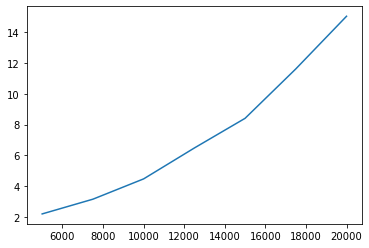

In [44]:
plt.plot([5000,7500,10000,12500,15000,17500,20000], times_1)

Creating full list

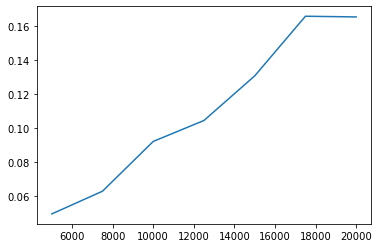

In [45]:
plt.plot([5000,7500,10000,12500,15000,17500,20000], times_2)

### On graph density

In [48]:
times_1 = []
times_2 = []

for density in tqdm([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]):
    er_flag_path = Path("data/timing/density/ER_" + str(density) + ".flag")
    er_matrix_path = er_flag_path.with_suffix('.pkl')
    er_count_path = er_flag_path.with_name("ER_" + str(density) + "-count.h5")
    er_matrix = load_sparse_matrix(er_matrix_path)
    er_simplex_file = h5py.File(er_count_path, 'r')
    
    pool = mp.Pool()
    er_arrays, er_links = prepare_shared_memory(er_matrix, 'er_')
    simplex_iterator = iter(er_simplex_file['Cells_2'][:10000])
    mp_iterator = product(simplex_iterator, [er_arrays])
    start = time()
    # Retrieving dag2 sets of vertices
    results = pool.imap(get_dag2_signature, mp_iterator)
    dags2 = []
    for elem in results:
        dags2.append(elem)
    end1 = time()
    times_1.append(end1-start)
    # Retrieving all dag2 subgraphs
    true_dags = []
    removed_list = []
    for simplex in dags2:
        for dag2 in simplex:
            for signature in get_combinations(dag2[1]):
                if (
                    np.all(signature) and
                    np.all([not (np.array(dag2[0]) == elem).all() for elem in removed_list])
                ):
                    removed_list.append( np.concatenate(
                            (dag2[0][:-2], [dag2[0][-1]] + [dag2[0][-2]])
                            )
                        )
                else:
                    true_dags.append(
                        (dag2[0],
                        signature)
                    )
    
    end2 = time()
    times_2.append(end2-end1)
    
    for element in er_links:
        element.unlink()

100%|██████████| 7/7 [03:02<00:00, 26.00s/it]


Retrieving targets and signatures

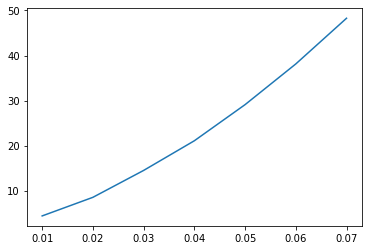

In [49]:
plt.plot([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07], times_1)

Creating full list

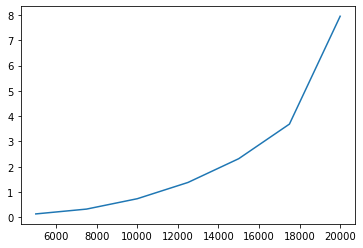

In [50]:
plt.plot([5000,7500,10000,12500,15000,17500,20000], times_2)

### On number of simplices

In [52]:
times_1 = []
times_2 = []
density = 0.02

for n_simplices in tqdm([10000,20000,30000,40000,50000,60000]):
    er_flag_path = Path("data/timing/density/ER_" + str(density) + ".flag")
    er_matrix_path = er_flag_path.with_suffix('.pkl')
    er_count_path = er_flag_path.with_name("ER_" + str(density) + "-count.h5")
    er_matrix = load_sparse_matrix(er_matrix_path)
    er_simplex_file = h5py.File(er_count_path, 'r')
    
    pool = mp.Pool()
    er_arrays, er_links = prepare_shared_memory(er_matrix, 'er_')
    simplex_iterator = iter(er_simplex_file['Cells_2'][:n_simplices])
    mp_iterator = product(simplex_iterator, [er_arrays])
    start = time()
    # Retrieving dag2 sets of vertices
    results = pool.imap(get_dag2_signature, mp_iterator)
    dags2 = []
    for elem in results:
        dags2.append(elem)
    end1 = time()
    times_1.append(end1-start)
    # Retrieving all dag2 subgraphs
    true_dags = []
    removed_list = []
    for simplex in dags2:
        for dag2 in simplex:
            for signature in get_combinations(dag2[1]):
                if (
                    np.all(signature) and
                    np.all([not (np.array(dag2[0]) == elem).all() for elem in removed_list])
                ):
                    removed_list.append( np.concatenate(
                            (dag2[0][:-2], [dag2[0][-1]] + [dag2[0][-2]])
                            )
                        )
                else:
                    true_dags.append(
                        (dag2[0],
                        signature)
                    )
    
    end2 = time()
    times_2.append(end2-end1)
    
    for element in er_links:
        element.unlink()

100%|██████████| 6/6 [03:16<00:00, 32.77s/it]


Retrieving targets and signatures

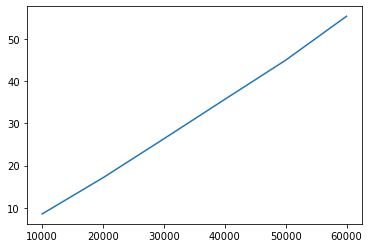

In [53]:
plt.plot([10000,20000,30000,40000,50000,60000], times_1)

Creating full list

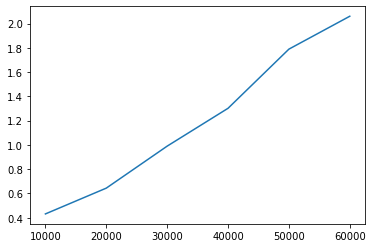

In [54]:
plt.plot([10000,20000,30000,40000,50000,60000], times_2)

### On simplex dimension

In [58]:
times_1 = []
times_2 = []
density = 0.04
n_simplices = 10000

for dimension in tqdm([1,2,3,4]):
    er_flag_path = Path("data/timing/density/ER_" + str(density) + ".flag")
    er_matrix_path = er_flag_path.with_suffix('.pkl')
    er_count_path = er_flag_path.with_name("ER_" + str(density) + "-count.h5")
    er_matrix = load_sparse_matrix(er_matrix_path)
    er_simplex_file = h5py.File(er_count_path, 'r')
    
    pool = mp.Pool()
    er_arrays, er_links = prepare_shared_memory(er_matrix, 'er_')
    simplex_iterator = iter(er_simplex_file['Cells_'+str(dimension)][:n_simplices])
    mp_iterator = product(simplex_iterator, [er_arrays])
    start = time()
    # Retrieving dag2 sets of vertices
    results = pool.imap(get_dag2_signature, mp_iterator)
    dags2 = []
    for elem in results:
        dags2.append(elem)
    end1 = time()
    times_1.append(end1-start)
    # Retrieving all dag2 subgraphs
    true_dags = []
    removed_list = []
    for simplex in dags2:
        for dag2 in simplex:
            for signature in get_combinations(dag2[1]):
                if (
                    np.all(signature) and
                    np.all([not (np.array(dag2[0]) == elem).all() for elem in removed_list])
                ):
                    removed_list.append( np.concatenate(
                            (dag2[0][:-2], [dag2[0][-1]] + [dag2[0][-2]])
                            )
                        )
                else:
                    true_dags.append(
                        (dag2[0],
                        signature)
                    )
    
    end2 = time()
    times_2.append(end2-end1)
    
    for element in er_links:
        element.unlink()

100%|██████████| 4/4 [01:57<00:00, 29.44s/it]


Retreiving targets and signatures

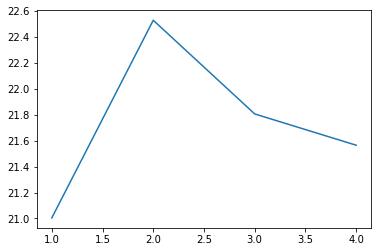

In [59]:
plt.plot([1,2,3,4], times_1)

Creating full list 

There's some problem in the list enumeration for dimension 1 that still has to be solved.

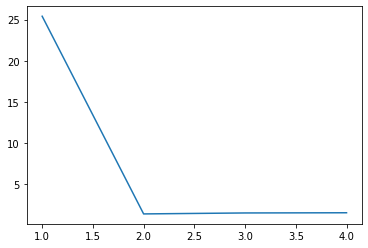

In [60]:
plt.plot([1,2,3,4], times_2)